# Data Exploration & Feature Engineering

This notebook documents the discovery and preparation phase of our project. It serves as a comprehensive Lab Journal for our data strategy, detailing why specific variables were selected, transformed, or excluded based on statistical evidence.

### Objectives

* **Data Exploration (EDA):** Identifying distributions, anomalies, and domain-integrity constraints.
* **Data Cleaning:** Handling missing values and rectifying structural inconsistencies.
* **Feature Engineering:** Encoding categorical variables and deriving new features.
* **Feature Selection:** Justifying the inclusion or exclusion of variables through correlation analysis and visual inspection.

### Project Architecture

To ensure reproducibility and clean production code, we follow a modular structure:

* this notebook: contains the narrative, visual analysis, and "proof of work" for rejected hypotheses.
* `/src` directory: contains the finalized Python scripts used to generate the modeling-ready dataset.

---

### Tips for your GitHub Presentation:

1. **Use Subheadings for "Rejections":** Instead of deleting work your companion didn't like, create a section called `## Feature Analysis: [Variable Name]`. Use a plot to show it wasn't useful, then explicitly state: *"Based on the lack of correlation shown above, this feature was excluded from the final pipeline."*
2. **Highlight the Source Link:** In the "Project Architecture" section, you can actually link to your script: `[Final Dataset Generator](../src/data_prep.py)`. This makes it very easy for a reviewer to jump between your "thinking" (the notebook) and your "doing" (the code).


## Data Exploration

In [41]:
%load_ext autoreload
%autoreload 2

import sys
import os

#Import data from src
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from src.city_translation import city_map
from src.data_utils import downsample_feature, plot_feature_correction, create_time_of_day_feature


In [43]:
# Load the dataset
file_path = "../data/tickets_data.csv"
data = pd.read_csv(file_path)

print("\nDataset Info:")
print(data.info())

print("\nUnique Values per Column:")
print(data.nunique())

print("\nFirst 5 Rows of the Dataset:")
print(data.head())

print("\nDataset Describe:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101017 entries, 0 to 101016
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Created               101017 non-null  object 
 1   CancelTime            15326 non-null   object 
 2   DepartureTime         101017 non-null  object 
 3   BillID                101017 non-null  int64  
 4   TicketID              101017 non-null  float64
 5   ReserveStatus         101017 non-null  int64  
 6   UserID                42543 non-null   float64
 7   Male                  101017 non-null  bool   
 8   Price                 101017 non-null  float64
 9   CouponDiscount        101017 non-null  float64
 10  From                  101017 non-null  object 
 11  To                    101017 non-null  object 
 12  Domestic              101017 non-null  int64  
 13  VehicleType           93473 non-null   object 
 14  VehicleClass          62567 non-null 

### Checking Respected Feature Domains 

**Price:**  $x \in \mathbb{R}_+$

In [44]:
zero_price_count = (data['Price'] <= 0).sum()
print(f"Total tickets with Price <= 0: {zero_price_count}")
print("\nCorresponding rows:\n", data[data['Price'] <= 0][['Price', 'CouponDiscount', 'Cancel']])

#dropping those values as they are outliers (all others have price equal or higher than 40000 rials)
data = data[data['Price'] > 0]
print("\nPrice range:\nMax:", data['Price'].max())
print("Min:", data['Price'].min())

Total tickets with Price <= 0: 2

Corresponding rows:
           Price  CouponDiscount  Cancel
6612 -1514000.0             0.0       1
8258        0.0             0.0       1

Price range:
Max: 383764590.0
Min: 40000.0


**CouponDiscount:** $x \in \mathbb{R}_+ \; \wedge \; x <= \text{Price} $

In [45]:
neg_discount_count = (data['CouponDiscount'] < 0).sum()
print(f"Total tickets with CouponDiscount < 0: {neg_discount_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] < 0][['Price', 'CouponDiscount', 'Cancel']])

higher_disc_count = (data['CouponDiscount'] > data['Price']).sum()
print(f"\nTotal tickets with CouponDiscount > Price: {higher_disc_count}")
print("\nCorresponding rows:\n", data[data['CouponDiscount'] > data['Price']][['Price', 'CouponDiscount', 'Cancel']])

# dropping all those values as they are very few
data = data[data['CouponDiscount'] >= 0]
data = data[data['CouponDiscount'] <= data['Price']]

Total tickets with CouponDiscount < 0: 1

Corresponding rows:
          Price  CouponDiscount  Cancel
10041  70000.0         -2000.0       0

Total tickets with CouponDiscount > Price: 9

Corresponding rows:
            Price  CouponDiscount  Cancel
2816     70000.0        220000.0       0
9780   1109000.0       1200000.0       0
11936    70000.0        110000.0       0
16773    70000.0        110000.0       0
26170    70000.0        110000.0       0
35858  1109000.0       1200000.0       0
45898  1078000.0       1200000.0       0
88361    70000.0        110000.0       0
99568    70000.0        110000.0       0


**DepartureTime:** $x > \text{Created}$

In [46]:
# Convert strings to datetime objects first
data['Created'] = pd.to_datetime(data['Created'])
data['DepartureTime'] = pd.to_datetime(data['DepartureTime'])

# Check if there is any strange value\n",
inverse_time_count = (data['DepartureTime'] <= data['Created']).sum()
print(f"Total tickets with DepartureTime pervious to Created: {inverse_time_count}")

Total tickets with DepartureTime pervious to Created: 0


## Data Cleaning

### Data Translation
Translate city names from Persian to English

In [47]:
#get all unique values in From & To columns together
unique_locations = pd.unique(data[['From', 'To']].values.ravel('K'))
print(f"\nTotal Unique Locations in 'From' and 'To' columns: {len(unique_locations)}")
print(unique_locations)


Total Unique Locations in 'From' and 'To' columns: 319
['گرگان' 'مشهد' 'شیراز' 'تبریز' 'تهران' 'بروجرد' 'اصفهان' 'یزد' 'رشت'
 'بوشهر' 'اهواز' 'اراک' 'مشهد (خراسان )' 'قم' 'سیرجان' 'کرج' 'آبادان'
 'زنجان' 'بافق' 'شوشتر' 'اردبیل' 'نجف آباد (اصفهان )' 'خرم آباد (لرستان )'
 'بهبهان' 'خرمشهر' 'رودسر' 'چالوس' 'جهرم' 'کیش' 'کرمان' 'قزوین'
 'گنبدکاووس' 'گلپایگان' 'بندرعباس' 'عسلويه' 'جلفا' 'دیر' 'ارومیه' 'زاهدان'
 'کرمانشاه' 'بابلسر' 'کاشمر' 'گرمسار' 'هشتگرد' 'اقلید' 'لنجان' 'همدان'
 'بیرجند' 'شهرکرد' 'مراغه' 'ساری' 'رامسر' 'بروجن' 'قایم شهر' 'جوین'
 'برخوار' 'سنندج' 'طبس' 'ماسال' 'شاهرود' 'سمنان' 'خواف' 'دامغان' 'دورود'
 'اندیمشک' 'شاهرود (سمنان )' 'تنکابن' 'آستارا' 'گناباد' 'لامرد'
 'کنگان (بوشهر)' 'نور' 'نایروبی' 'استانبول' 'چابهار' 'قشم' 'عسلویه'
 'شهرضا' 'ایرانشهر' 'بابل' 'مهاباد (آذربایجان غربی )' 'ملایر' 'زواره'
 'میلان' 'تاکستان' 'خوی' 'محمدیه' 'خرم دره' 'کاشان' 'گناوه' 'دزفول'
 'تویسرکان' 'خلخال' 'سرخس' 'مرند' 'نیشابور' 'بشرویه' 'ایذه' 'حکاری'
 'کازرون' 'ایلام' 'میانه' 'بانه' 'نوشهر'

In [48]:
# Apply the mapping (found in /src/city_translation.py)
data['From'] = data['From'].map(city_map).fillna(data['From'])
data['To'] = data['To'].map(city_map).fillna(data['To'])

# Check for anything missed
print("Missed Cities in From:", data[~data['From'].isin(city_map.values())]['From'].unique())
print("Missed Cities in To:", data[~data['To'].isin(city_map.values())]['To'].unique())

Missed Cities in From: []
Missed Cities in To: []


### Remove useless columns

We remove the following variables:
- `HashPassportNumber_p`, `UserID`, `HashEmail`, `BillID`, `BuyerMobile`, `TicketID`: identification variables, not useful to the prediction of the cancellation probability;
- `CancelTime`: contains data only about the cancelled tickets, if we would add this variable to the model we wold have target leakage
- `VehicleType`: there are too many categories in this variable, it's not possible to retrieve any information about cancellation

In [49]:
data = data.drop(columns=['HashPassportNumber_p', 'UserID', 'HashEmail', 'BillID', 'BuyerMobile', 'TicketID', 'CancelTime','VehicleType'])


We also remove `ReserveStatus`, as we don't have information about the categories meaning. Furthermore, as shown in the plot, there is the risk of target leakage (some categories have high cancellation rates, while others have 0%).

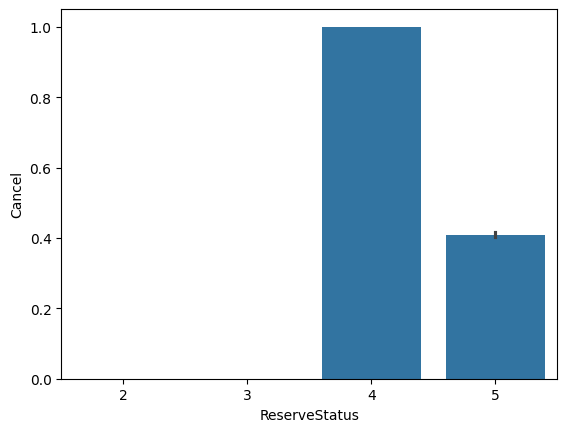

In [50]:
sns.barplot(x='ReserveStatus', y = 'Cancel', data=data)

data = data.drop(columns=['ReserveStatus'])

### Missing Values

In [51]:
missing_info = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data)) * 100
})

print(missing_info.sort_values(by='Missing Percentage', ascending=False))

                Missing Count  Missing Percentage
VehicleClass            38441           38.058512
DepartureTime               0            0.000000
Male                        0            0.000000
Price                       0            0.000000
Created                     0            0.000000
CouponDiscount              0            0.000000
From                        0            0.000000
To                          0            0.000000
Domestic                    0            0.000000
TripReason                  0            0.000000
Vehicle                     0            0.000000
Cancel                      0            0.000000
NationalCode                0            0.000000


The variable `VehicleClass` contains too many missing values to drop them, so we label them as "Unknown".

In [52]:
data['VehicleClass'] = data['VehicleClass'].fillna('Unknown')

### Correlation Check
**Vehicle=InternationalPlane - Domestic=False** 

In [53]:
print("Number of InternationalPlane:", len(data[data['Vehicle']=="InternationalPlane"]))
print("Number of Domestic=False:", len(data[data['Domestic']==0]))
print("Intersection:", len(data[(data['Vehicle']=="InternationalPlane") & (data['Domestic']==0)]))

Number of InternationalPlane: 795
Number of Domestic=False: 795
Intersection: 795


Result: clear 1-1 correlation. We manage it by merging the two categories `Plane` and `InternationalPlane`. 

In [54]:
data['Vehicle'] = data['Vehicle'].replace('InternationalPlane', 'Plane')
# Verify the merge
print("Unique categories after merge:", data['Vehicle'].unique())

Unique categories after merge: ['Plane' 'Bus' 'Train']


**Vehicle=Train - VehicleClass=Unknown**

In [55]:
print("Number of Train:", len(data[data['Vehicle']=="Train"]))
print("Number of VehicleClass=Unknown:", len(data[data['VehicleClass']=="Unknown"]))
print("Intersection:", len(data[(data['Vehicle']=="Train") & (data['VehicleClass']=="Unknown")]))

Number of Train: 38441
Number of VehicleClass=Unknown: 38441
Intersection: 38441


Result: clear 1-1 correlation.

Interpretation: it seems like for trains there is not a differentiation between standard and luxury class.

First possible solution: merge the `Unknown` class under the category `VehicleClass=0`, which means assuming that all trains only have the standard class. We check the cancellation rate in the two classes.

Cancellation Rate for Trains (Unknown Class): 18.46%
Cancellation Rate for Standard Vehicles (Class 0): 12.52%
Cancellation Rate for Luxury Vehicles (Class 1): 13.35%


<Axes: xlabel='VehicleClass', ylabel='Cancel'>

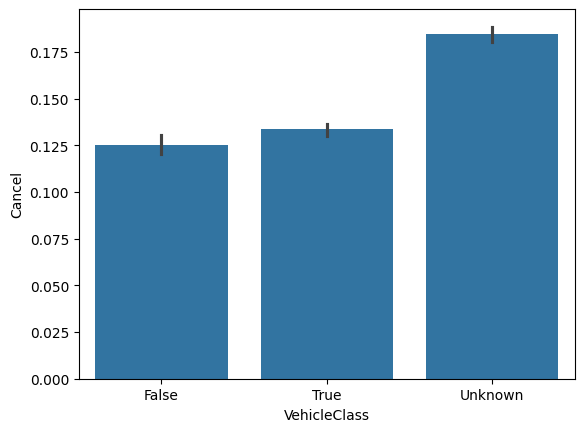

In [56]:
train_cancel_rate = data[data['Vehicle'] == 'Train']['Cancel'].mean()
standard_cancel_rate = data[data['VehicleClass'] == 0]['Cancel'].mean()
luxury_cancel_rate = data[data['VehicleClass'] == 1]['Cancel'].mean()

print(f"Cancellation Rate for Trains (Unknown Class): {train_cancel_rate:.2%}")
print(f"Cancellation Rate for Standard Vehicles (Class 0): {standard_cancel_rate:.2%}")
print(f"Cancellation Rate for Luxury Vehicles (Class 1): {luxury_cancel_rate:.2%}")

sns.barplot(x='VehicleClass', y = 'Cancel', data=data)


The $5.94\%$ difference between the cancellation rate of `VehicleClass=0` and `VehicleClass=Unknown` is pretty high, so merging the two classes would inject noise in the category. 

At the same time, the difference between the two categories `VehicleClass=0` and `VehicleClass=1` is not that relevant, so we decided to directly drop the `VehicleClass` variable, also removing correlation from the dataset.

In [57]:
data=data.drop(columns=['VehicleClass'])

## Feature Engineering

### Feature Extraction

- **LeadTime_Days** (float): how many days in advance the ticket was booked. 

*Hypothesis:* people who buy tickets much time in advance, are more likely to cancel due to changing of plans.

Since the distribution presents outliers and is skewed, we also apply the log transformation, creating the variable `LogLeadTime`.

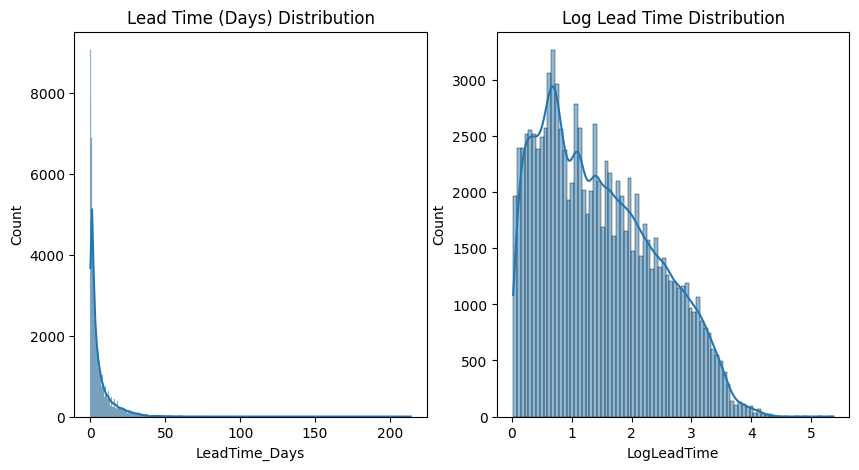

In [ ]:
data['LeadTime_Days'] = (data['DepartureTime'] - data['Created']).dt.total_seconds() / 86400
data['LogLeadTime'] = np.log1p(data['LeadTime_Days'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x='LeadTime_Days',data=data, kde=True, ax=axes[0])
sns.histplot(x='LogLeadTime',data=data, kde=True, ax=axes[1])
axes[0].set_title('Lead Time (Days) Distribution')
axes[1].set_title('Log Lead Time Distribution')
plt.show()

data=data.drop(columns=['Created', 'LeadTime_Days'])

- **PercentageDiscount** (float): percentage of the discount over the price.

*Hypothesis:* people who bought a ticket with a discount paid less for it, so are more prone to cancelling it; moreover, the coupon percentage is much more informative than the absolute value of discount.

However, after creating the variable we noticed that only about $6\%$ of tickets were bought with a discount, so it is a very imbalanced data and may inject noise in the model rather than being useful for prediction.

For good measure, we created the binary variable `Has_Discount` and drawn the conclusion that there is not an actual difference in cancellation rate between having or not a discount. Thus we dropped all the three of them: `CouponDiscount`, `PercentageDiscount` and `Has_Discount`.

Percentage of tickets bought with discount: 5.95%


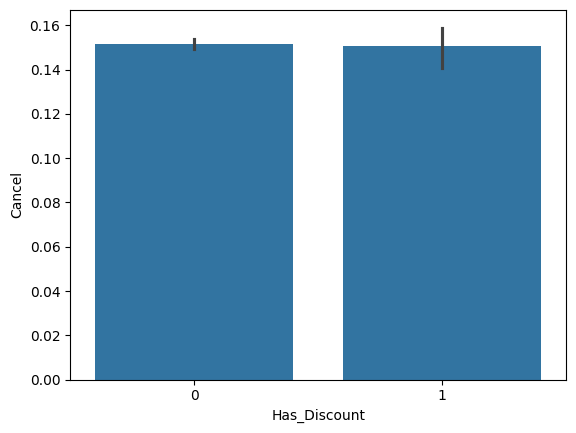

In [19]:
# as just 5% of total tickets have discount and they don't have any effect on the cancelation so we decide to drop it too

data['PercentageDiscount'] = data['CouponDiscount'] / data['Price']

print(f"Percentage of tickets bought with discount: {len(data[data['PercentageDiscount']>0])/len(data):.2%}")

data['Has_Discount'] = (data['CouponDiscount'] > 0).astype(int)
sns.barplot(x='Has_Discount', y='Cancel', data=data)

data = data.drop(columns=['CouponDiscount', 'PercentageDiscount', 'Has_Discount'])


- **LogPrice** (float)

The `Price` range is $[40000.0, 383764590.0]$ but its distribution is strongly skewed: almost all the data is squished into the bottom 0.1, with a few dots stretching way far up. There are outliers: most tickets are cheap (under 5M), but there are a few extremely expensive (100M+). These outliers can confuse linear models like Logistic Regression, so we log-transform `Price`.

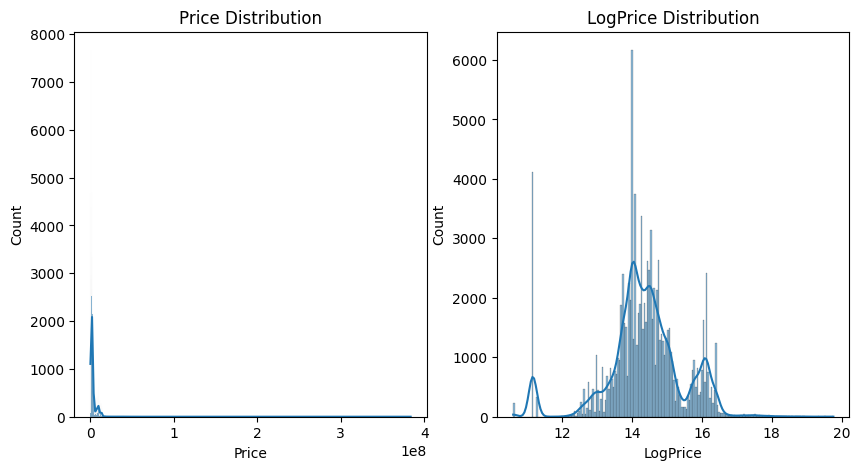

In [20]:
data['LogPrice']=np.log(data['Price'])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x='Price',data=data, kde=True, ax=axes[0])
sns.histplot(x='LogPrice',data=data, kde=True, ax=axes[1])
axes[0].set_title('Price Distribution')
axes[1].set_title('LogPrice Distribution')
plt.show()

data=data.drop(columns=['Price'])

- **MonthDeparture, DayOfWeekDeparture, HourDeparture** (datetime)
  
We analyzed the relationship between flight cancellations and various temporal features: month, day of the week, and day of the month of `DepartureTime`. Our goal was to identify seasonal or hourly patterns that influence cancellation probability.

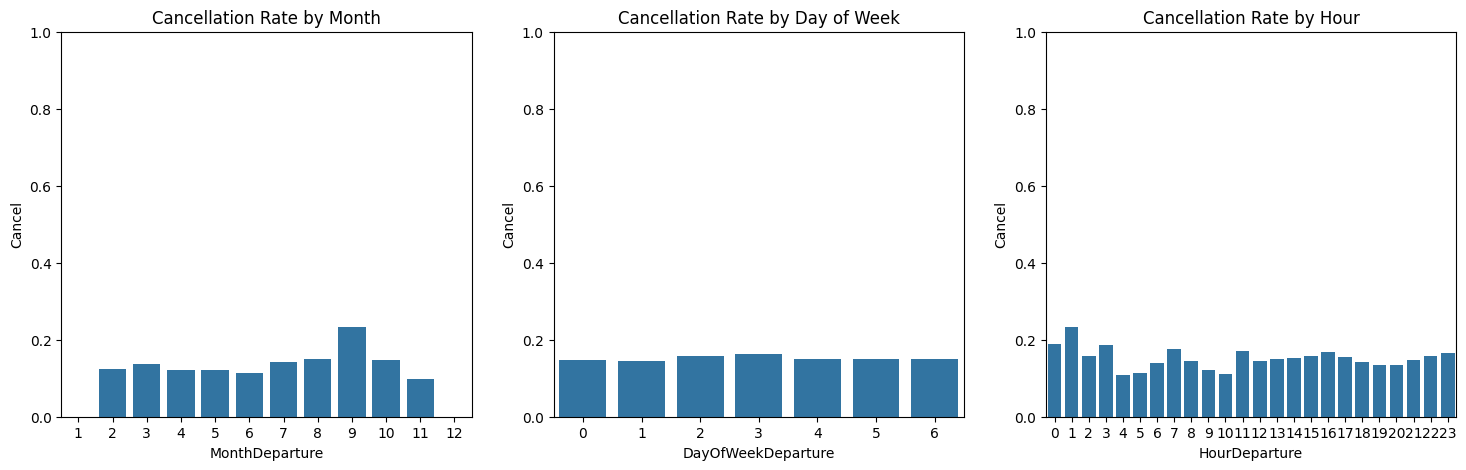

In [21]:
# Extract DepartureTime features
data['MonthDeparture'] = data['DepartureTime'].dt.month
data['DayOfWeekDeparture'] = data['DepartureTime'].dt.dayofweek
data['HourDeparture'] = data['DepartureTime'].dt.hour

# Plot Cancel Rate vs Feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Month
sns.barplot(x='MonthDeparture', y='Cancel', data=data, ax=axes[0], errorbar=None)
axes[0].set_title('Cancellation Rate by Month')
axes[0].set_ylim(0, 1) # Fix y-axis to see true scale

# Plot Day of Week
sns.barplot(x='DayOfWeekDeparture', y='Cancel', data=data, ax=axes[1], errorbar=None)
axes[1].set_title('Cancellation Rate by Day of Week')
axes[1].set_ylim(0, 1)

# Plot Hour
sns.barplot(x='HourDeparture', y='Cancel', data=data, ax=axes[2], errorbar=None)
axes[2].set_title('Cancellation Rate by Hour')
axes[2].set_ylim(0, 1)

plt.show()


Results:

- `HourDeparture`: A clear correlation was observed, with significantly higher cancellation rates during late-night and early-morning hours. However a linear model (like Logistic Regression) sees "Hour 0" as very different from "Hour 23" because of numerical distance, but in reality they are adjacent and have similar high risks. It also cannot draw a "U" shape, but only draw a straight line. So we apply binning, creating a simplified feature `TimeOfDay` containing the classes Morning (06:00 - 11:59), Afternoon (12:00 - 17:59), Evening (18:00 - 22:59), Night (23:00 - 05:59). This allows the model to capture the high-risk vs. low-risk hours.

- `DayOfWeekDeparture`: This variable showed a uniform distribution with no statistically significant impact on the target variable, so we drop it.
  
- `MonthDeparture`:  A sharp spike in cancellations was identified in September. However, contextual research indicates this peak coincided the nationwide protests in Iran (Sept 2022). This represents an exogenous shock rather than a recurring seasonal trend. To prevent the model from skewing to the non-recurring events of September 2022, we perform **outlier mitigation**: we downsample the cancelled flights for that month to align with the baseline cancellation rate of approximately $15\%$ seen in adjacent months. Moreover, since the primary variance was tied to a one-time event, and there are very few data for the months of January and December, this feature will later be removed to improve model generalization.

<Axes: xlabel='TimeOfDay', ylabel='Cancel'>

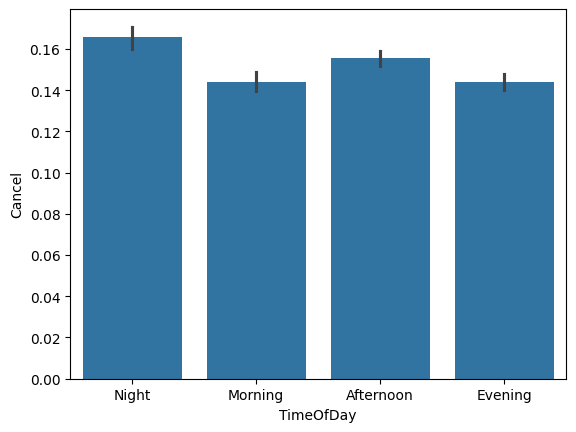

In [22]:
# Create Categorical TimeOfDay (replaces HourDeparture)
data = create_time_of_day_feature(data, hour_col='HourDeparture')

sns.barplot(x='TimeOfDay', y='Cancel', data=data)


--- Correction for MonthDeparture category 9 ---
Target Rate: 13.50%
Current Rate: 23.42%
Removing 1675 cancelled tickets to align rates...
New Rate: 14.99%
Cancellation rate reduced by: 8.44 percentage points


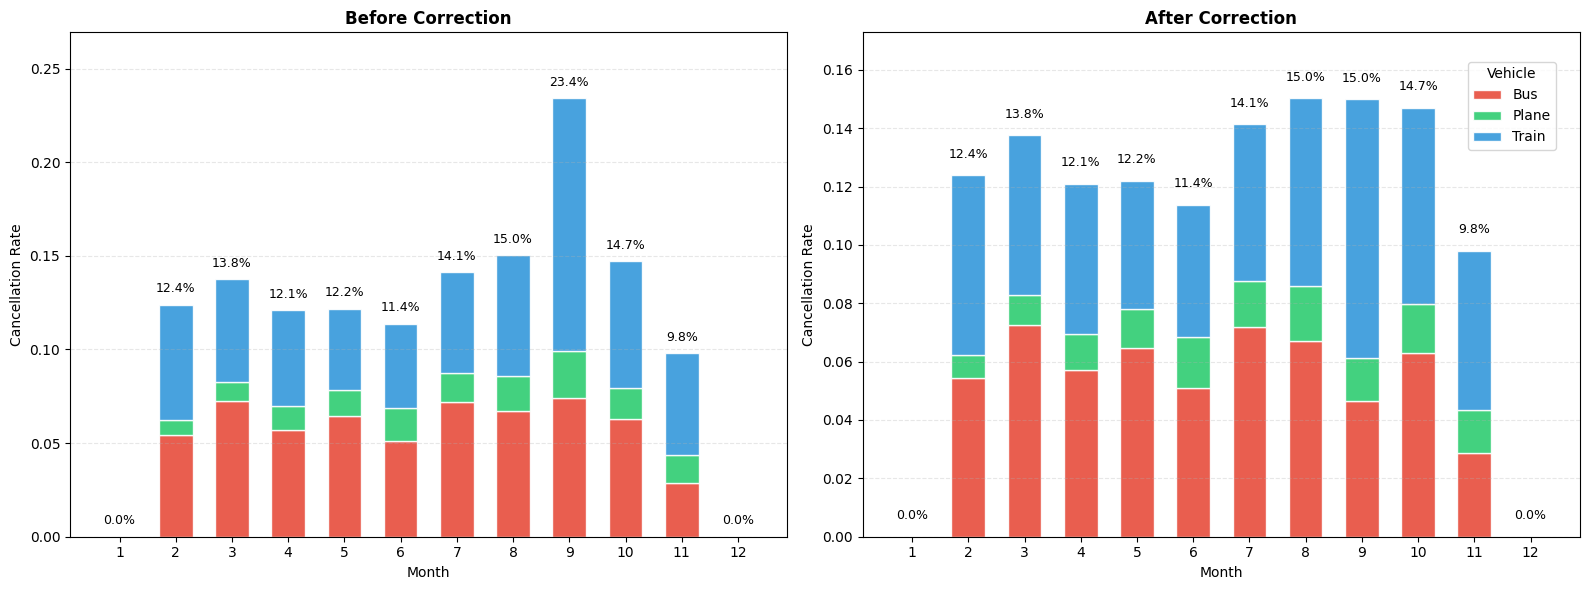

In [23]:

# Data correction: downsampling september cancelled tickets
data_before = data.copy()
data = downsample_feature(
    df=data, 
    feature_col='MonthDeparture', 
    target_col='Cancel',
    category_value=9
)

# Optional visualization
plot_feature_correction(
    df_original = data_before, 
    df_corrected = data, 
    feature_col='MonthDeparture', 
    target_col='Cancel', 
    conditional_col='Vehicle' 
)

data = data.drop(columns=['DepartureTime', 'DayOfWeekDeparture','MonthDeparture'])

### Categorical Encoding
**Label Encoding**

`TripReason` and `Male` have 2 unique values, but different type (string, bool). For consistency and easier future management, we turn them in integers.

In [24]:
data['TripReason'] = data['TripReason'].map({'Work': 1, 'Int': 0})
data['Male'] = data['Male'].astype(int)

**One Hot Encoding**

We do one hot encoding on the variable `Vehicle`, which now contains three cathegories (Bus, Train and Plane).

In [25]:
cols_to_encode = ['Vehicle', 'TimeOfDay']

encoder = OneHotEncoder(sparse_output=False, dtype=int)

encoded_array = encoder.fit_transform(data[cols_to_encode])
encoded_columns = encoder.get_feature_names_out(cols_to_encode)

encoded_data = pd.DataFrame(encoded_array, columns=encoded_columns, index=data.index)

# Drop original categorical columns and concatenate with encoded columns
data = data.drop(columns=cols_to_encode)
data = pd.concat([data, encoded_data], axis=1)

print("\nData After Encoding:")
data.info()


Data After Encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Male                 99330 non-null  int64  
 1   From                 99330 non-null  object 
 2   To                   99330 non-null  object 
 3   Domestic             99330 non-null  int64  
 4   TripReason           99330 non-null  int64  
 5   Cancel               99330 non-null  int64  
 6   NationalCode         99330 non-null  int64  
 7   LogLeadTime          99330 non-null  float64
 8   LogPrice             99330 non-null  float64
 9   Vehicle_Bus          99330 non-null  int64  
 10  Vehicle_Plane        99330 non-null  int64  
 11  Vehicle_Train        99330 non-null  int64  
 12  TimeOfDay_Afternoon  99330 non-null  int64  
 13  TimeOfDay_Evening    99330 non-null  int64  
 14  TimeOfDay_Morning    99330 non-null  int64  
 15  TimeOfDay_Nigh

### Target Encoding

- **User_Cancel_Rate, User_Total_Tickets**(float, int): rate of cancellation for each user and total number of ticket booked.

*Hypothesis:* a user with a high cancellation rate is likely to cancel again.

- **From_Rate, To_Rate, Route_Rate** (float): cancellation rate per departure city, arrival city and route.
  
The categorical variables `From` and `To` have hundreds of unique values, making traditional One-Hot Encoding computationally expensive and prone to creating a sparse, overfitted feature space. To address this, we compute the historical cancellation probability for each city acting as an origin and a destination, respectively. 

We also created a composite feature `Route` by concatenating the origin and destination (e.g., "Shiraz_Zahedan"). This captures the specific interaction between two points, which might be more predictive than the individual cities alone.

We are testing two distinct hypotheses for the model:

- Providing only `Route_Rate`: this assumes the specific path is the primary driver of cancellations.

- Providing both `From_Rate` and `To_Rate`: this allows the model to learn if a cancellation is due to the single departure or destination's airports, potentially generalizing better to new, rare routes.

**Note:** for both user history and city history we apply the following strategies.

1. **Leave-One-Out (LOO) Smoothed Rate:**
$$
    \text{LOO Smoothed Rate} = \frac{(\text{Sum} - y_i) + (\alpha \cdot \mu)}{\text{Count -1} + \alpha}    
$$    
where 
* $\text{Sum}$ is the total number of cancellations for that category.
* $y_i$ is the target value (0 or 1) of the current row being encoded (subtracted to prevent the model from "seeing" the answer).
* $\text{Count}$ is the total number of trips for that category (we subtract 1 to account for the removed observation).
* $\mu$ is the global average cancellation rate.
* $\alpha$ is the smoothing weight.

This is useful to prevent overfitting, ensuring that a row's target variable is not used to generate its own feature value. It also handles sparsity: the smoothing term $\alpha \cdot \mu$ pulls rare categories (e.g., a user with very few trips) towards the global average. A lower $\alpha$ was chosen for users to allow the model to capture individual behavior quickly, while a higher weight is used for routes/cities to ensure stability, given the lower transaction frequency per user compared to airport-level data.

2. **Differentiate train and test data:**   

The actual cancellation rates will be computed only for users, cities and routes in the train dataset. While for the train set we apply the LOO smoothed rate, for the test set we apply the standard smoothed rate using the statistics (count, mean, $\mu$) calculated from the training data: 
  
  $$

    \text{Smoothed Rate} = \frac{(\text{Count}\cdot \text{Mean}) + (\alpha \cdot \mu)}{\text{Count} + \alpha}    

$$  

  If an element only appears in the test dataset, its cancellation rate will be set to the training dataset mean, in order to avoid data leakage.
  If a user, city, or route in the test set does not appear in the training set (i.e., $\text{Count}_{train} = 0$), its cancellation rate is set to the training dataset mean ($\mu$) to prevent data leakage.

In [26]:
def get_loo_smoothed_rate(df, group_col, target_col, weight, global_mean):
    """
    Calculates the Smoothed Rate using Leave-One-Out (LOO) logic.
    Returns a pandas Series aligned with the original DataFrame index.
    """
    # Compute total sum and count for the group (aligned to rows)
    total_sum = df.groupby(group_col)[target_col].transform('sum')
    total_count = df.groupby(group_col)[target_col].transform('count')
    
    # Leave-One-Out: subtract the current row's information
    loo_sum = total_sum - df[target_col]
    loo_count = total_count - 1
    
    # Apply the smoothing formula
    smoothed_rate = (loo_sum + weight * global_mean) / (loo_count + weight)
    
    return smoothed_rate


In [27]:
feature_config = {
        'From': ('From', 20),
        'To': ('To', 20),
        'Route': ('Route', 20),
        'NationalCode': ('User', 5)  # Maps NationalCode to "User"
    }

target_col = 'Cancel'

# Calculate global mean from train only
global_mean = data[target_col].mean()

# Create Route
data['Route'] = data['From'].astype(str) + ' to ' + data['To'].astype(str)

# Encoding loop
for col, (var_name, weight) in feature_config.items():

    # Encoding Training Set
    data[f'{var_name}_Rate'] = get_loo_smoothed_rate(
        data, 
        group_col=col, 
        target_col=target_col, 
        weight=weight, 
        global_mean=global_mean
    )

    # Fill NaNs in train set (if an element has only 1 occurrence, loo_count is 0)
    data[f'{var_name}_Rate'] = data[f'{var_name}_Rate'].fillna(global_mean)
    
# Drop original columns
cols_to_drop = list(feature_config.keys())
data = data.drop(columns=cols_to_drop)

# Updated Dataset

In [28]:
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Male                 99330 non-null  int64  
 1   Domestic             99330 non-null  int64  
 2   TripReason           99330 non-null  int64  
 3   Cancel               99330 non-null  int64  
 4   LogLeadTime          99330 non-null  float64
 5   LogPrice             99330 non-null  float64
 6   Vehicle_Bus          99330 non-null  int64  
 7   Vehicle_Plane        99330 non-null  int64  
 8   Vehicle_Train        99330 non-null  int64  
 9   TimeOfDay_Afternoon  99330 non-null  int64  
 10  TimeOfDay_Evening    99330 non-null  int64  
 11  TimeOfDay_Morning    99330 non-null  int64  
 12  TimeOfDay_Night      99330 non-null  int64  
 13  From_Rate            99330 non-null  float64
 14  To_Rate              99330 non-null  float64
 15  Route_Rate           99330 non-null 

,Male,Domestic,TripReason,Cancel,LogLeadTime,LogPrice,Vehicle_Bus,Vehicle_Plane,Vehicle_Train,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,From_Rate,To_Rate,Route_Rate,User_Rate
0,1,1,1,0,2.450776,15.702580,0,1,0,0,0,0,1,0.145227,0.148492,0.156824,0.114425
1,1,1,0,0,1.269152,16.066802,0,1,0,0,0,0,1,0.163560,0.148492,0.182062,0.137310
2,0,1,1,0,0.549464,14.508658,1,0,0,0,0,1,0,0.104223,0.185071,0.145818,0.114425
3,0,1,0,0,0.627534,10.596635,0,0,1,0,0,1,0,0.127785,0.031021,0.035157,0.114425
4,1,1,0,0,0.907672,13.937728,1,0,0,0,0,0,1,0.142249,0.115205,0.093713,0.098079


## Feature Selection

In [29]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [30]:

variables = ['Male', 'Domestic', 'TripReason', 'Cancel', 'Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'LogLeadTime', 'LogPrice', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Morning', 'TimeOfDay_Night', 'From_Rate', 'To_Rate', 'Route_Rate', 'User_Rate']
cont_vars = ['LogLeadTime', 'LogPrice', 'From_Rate', 'To_Rate', 'Route_Rate', 'User_Rate']
categ_vars = ['Male', 'Domestic', 'TripReason', 'Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Morning', 'TimeOfDay_Night']

target_var = 'Cancel'


### Distributions

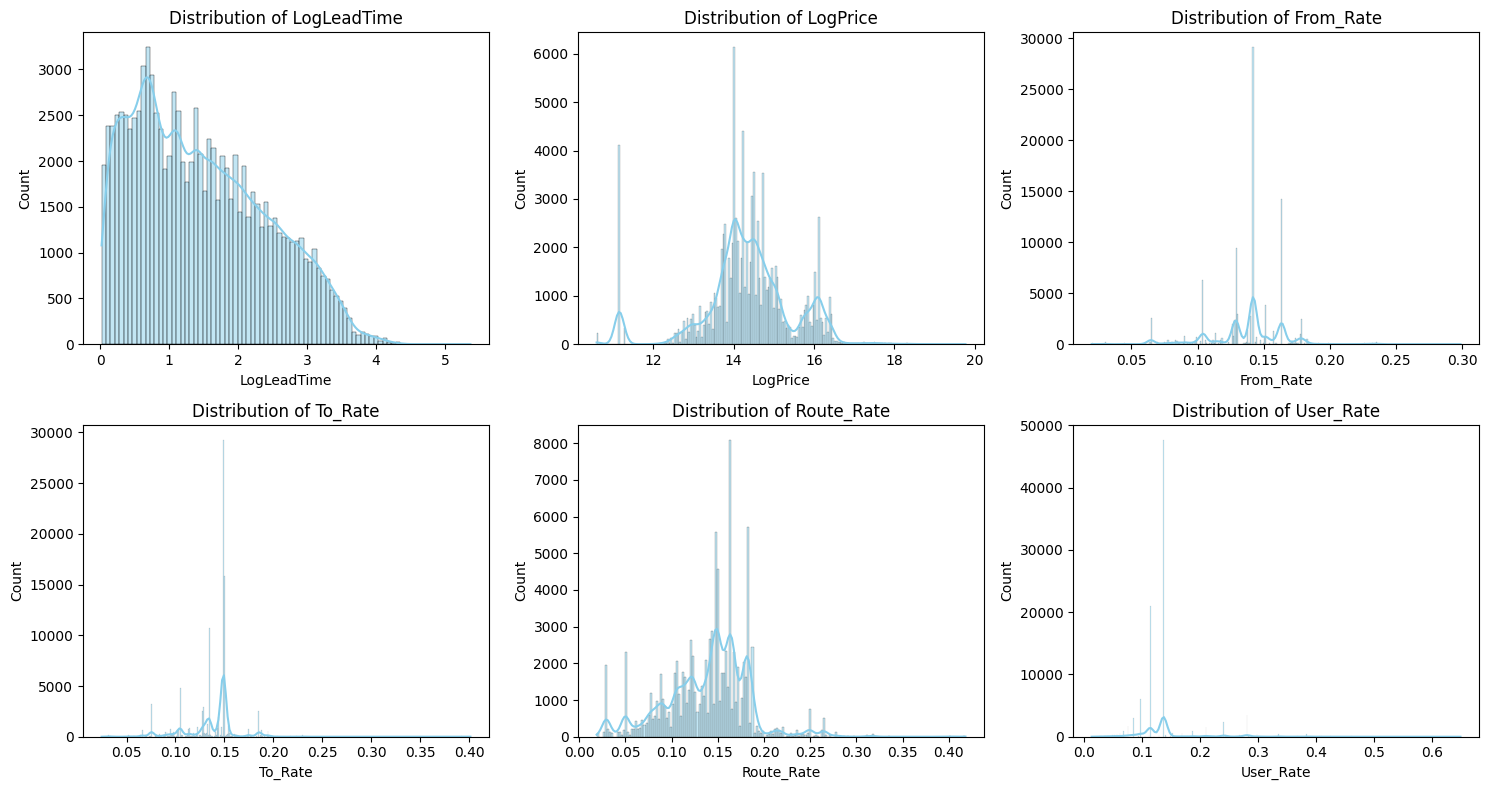

In [31]:
# Plot Continuous Variables
n_cols = 3
n_rows = (len(cont_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cont_vars):
    sns.histplot(data=data, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')

# Hide empty subplots
for i in range(len(cont_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



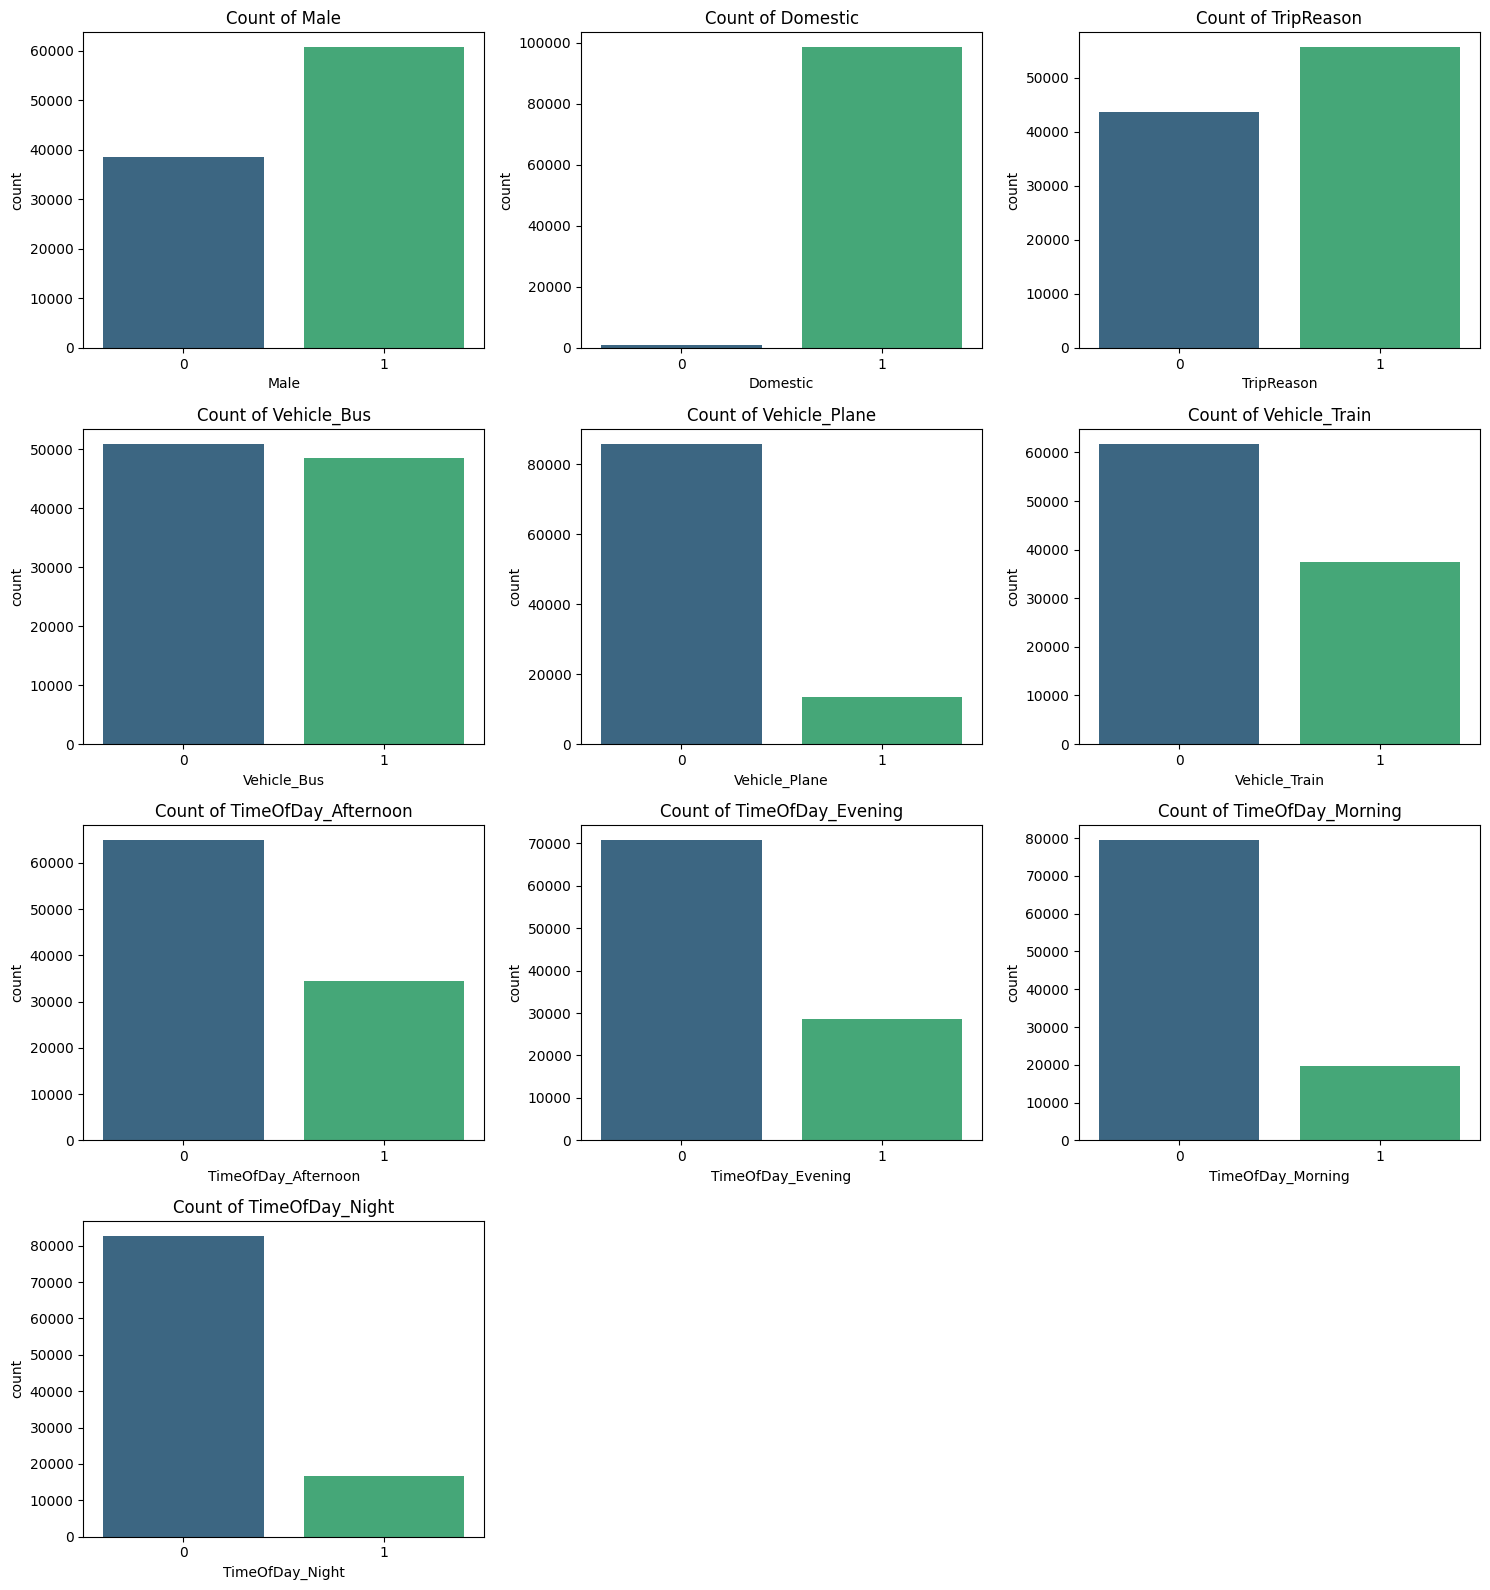

In [32]:
# Plot Categorical Variables
n_cols = 3
n_rows = (len(categ_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categ_vars):
    
    # FIX: Assign 'x' variable to 'hue' and set legend=False
    sns.countplot(data=data, x=col, hue=col, ax=axes[i], palette='viridis', legend=False)
    
    axes[i].set_title(f'Count of {col}')
    axes[i].tick_params(axis='x', rotation=0)

# Hide empty subplots
for i in range(len(categ_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Correlation Matrix

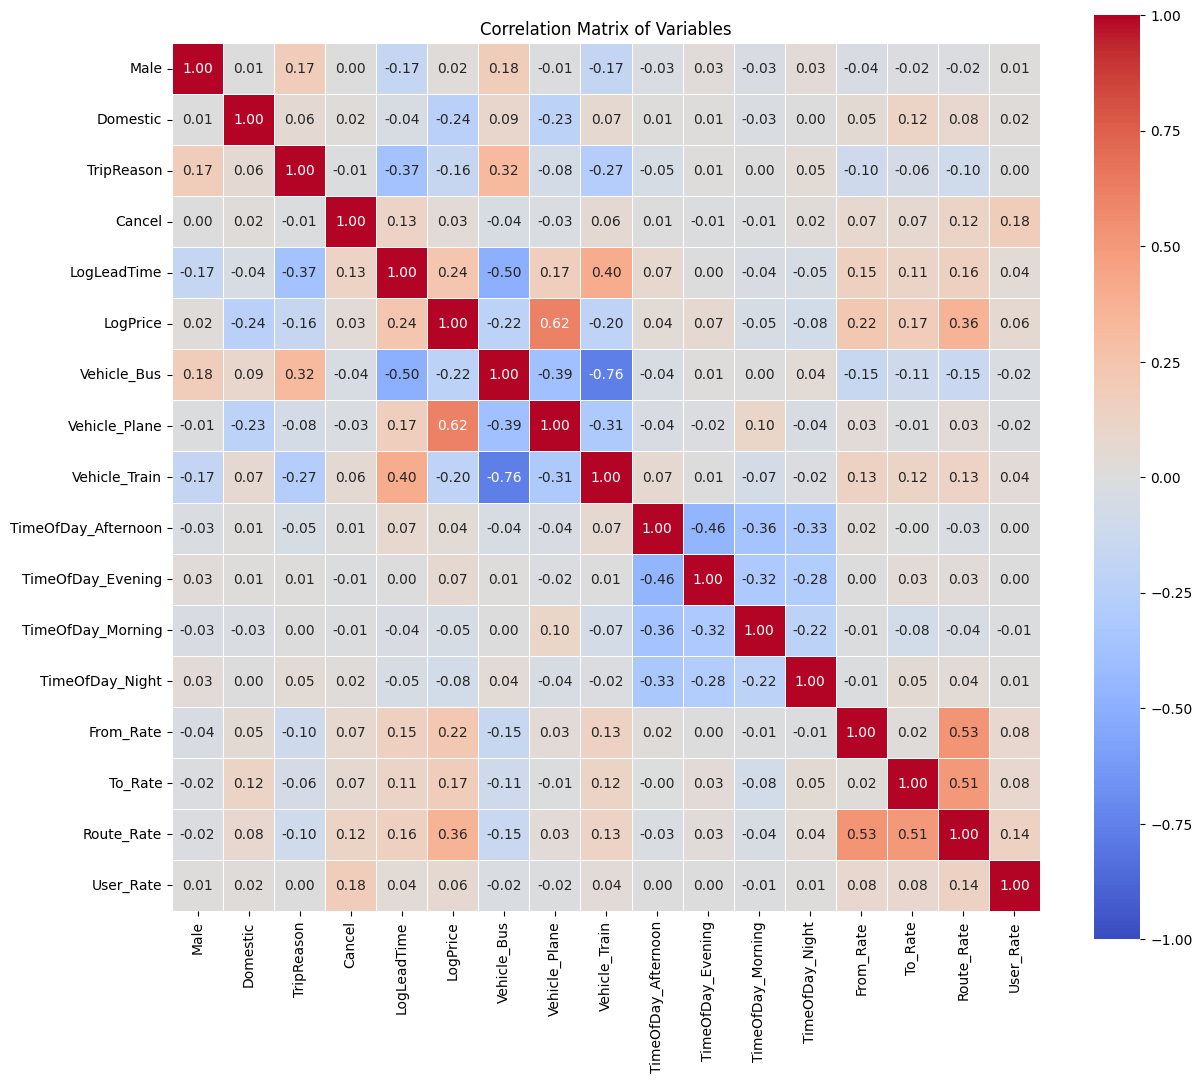

In [33]:
plt.figure(figsize=(14, 12))

# We include the target variable in the correlation matrix
# Ensure all data is numeric for correlation. 
# If 'TripReason' or 'Created' are strings, they must be encoded first.
# Here we calculate correlation only for numeric columns.
numeric_df = data.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

# Mask the upper triangle for better readability
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5)
plt.title('Correlation Matrix of Variables')
plt.show()

### Correlation wrt Cancel

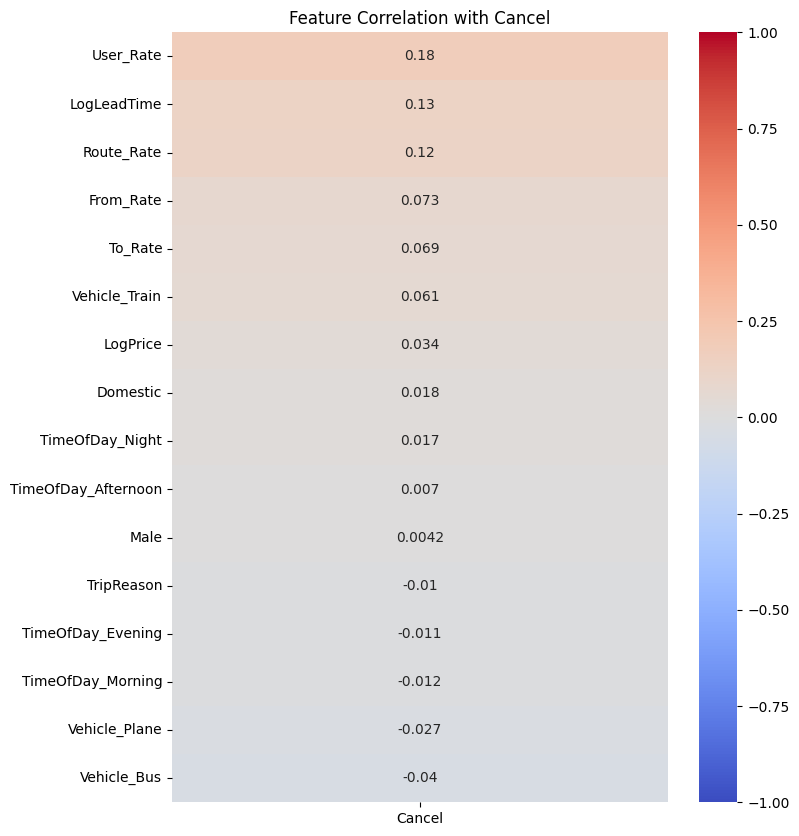

In [34]:
plt.figure(figsize=(8, 10))

# Get correlation series for 'Cancel' and sort it
target_corr = numeric_df.corr()[[target_var]].sort_values(by=target_var, ascending=False)

# Remove the target itself from the list to see other features clearly
target_corr = target_corr.drop(target_var)

sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Feature Correlation with {target_var}')
plt.show()

### Boxplot

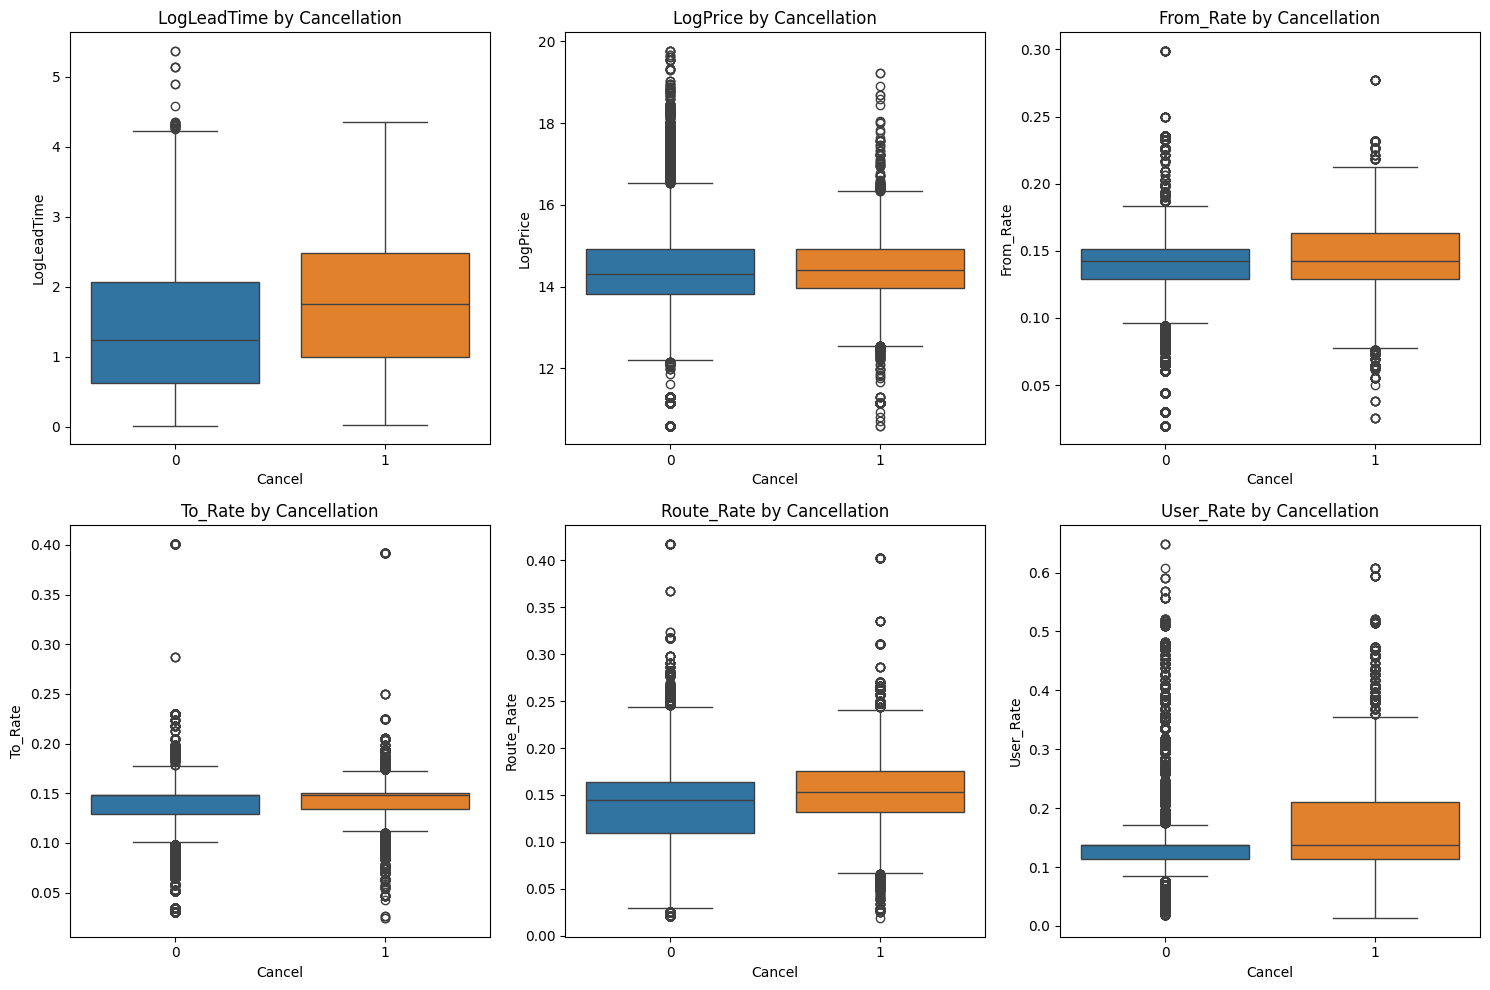

In [35]:
n_cols = 3
n_rows = (len(cont_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cont_vars):
    # Boxplot shows the distribution spread for Cancel=0 vs Cancel=1
    sns.boxplot(data=data, x=target_var, y=col, ax=axes[i], hue=target_var, legend=False)
    axes[i].set_title(f'{col} by Cancellation')

# Hide empty subplots
for i in range(len(cont_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Stacked Bar Charts & Crosstabs (Categorical vs Target)


--- Crosstab: Male vs Cancel ---
Cancel         0         1
Male                      
0       0.864511  0.135489
1       0.861532  0.138468

--- Crosstab: Domestic vs Cancel ---
Cancel           0         1
Domestic                    
0         0.931122  0.068878
1         0.862146  0.137854

--- Crosstab: TripReason vs Cancel ---
Cancel             0         1
TripReason                    
0           0.858791  0.141209
1           0.865750  0.134250

--- Crosstab: Vehicle_Bus vs Cancel ---
Cancel              0         1
Vehicle_Bus                    
0            0.849104  0.150896
1            0.876978  0.123022

--- Crosstab: Vehicle_Plane vs Cancel ---
Cancel                0         1
Vehicle_Plane                    
0              0.858972  0.141028
1              0.886511  0.113489

--- Crosstab: Vehicle_Train vs Cancel ---
Cancel                0         1
Vehicle_Train                    
0              0.879046  0.120954
1              0.835729  0.164271

--- Crosstab

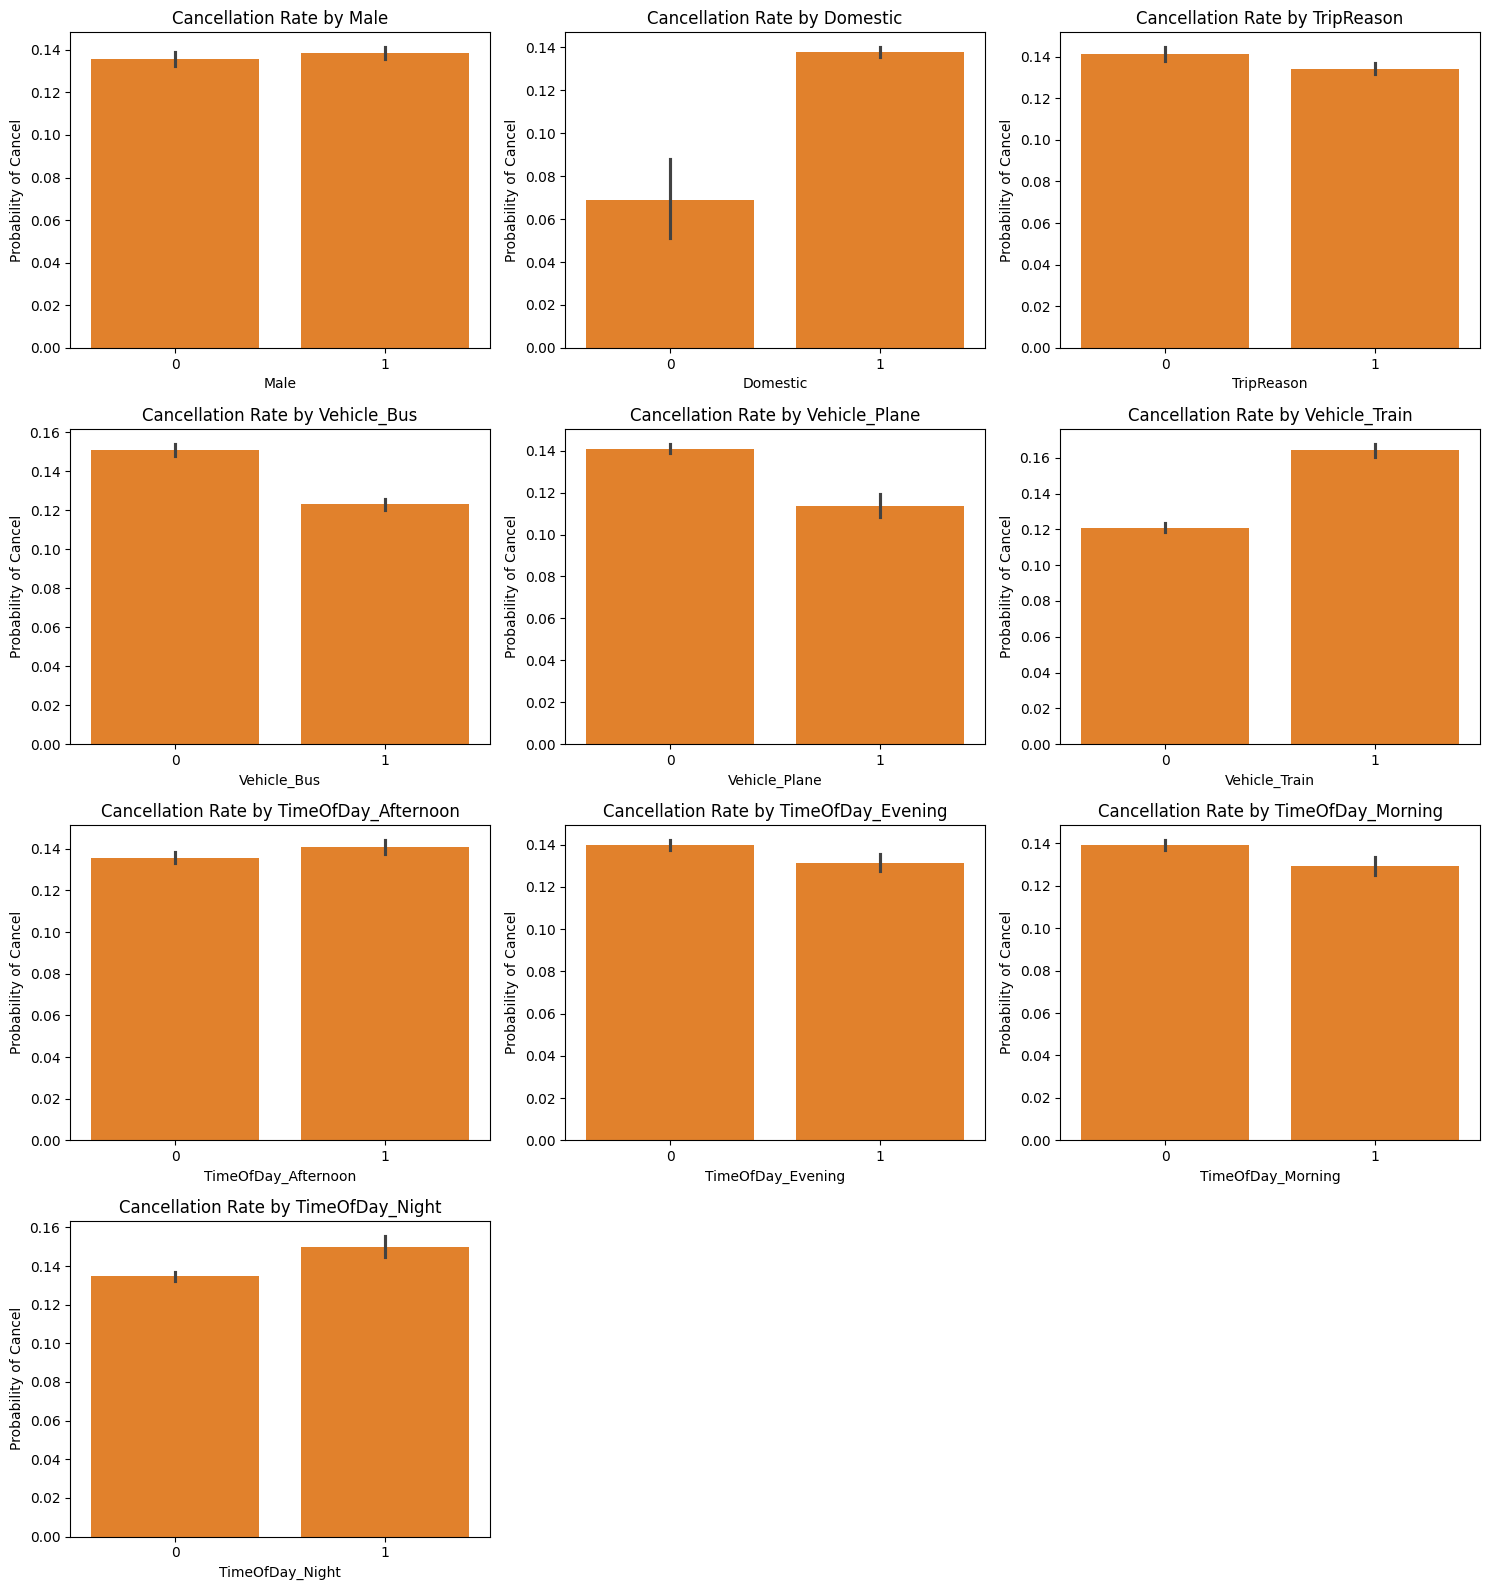

In [36]:
# We loop through categorical vars to print the Crosstab and plot the Stacked Bar
for col in categ_vars:
    print(f"\n--- Crosstab: {col} vs {target_var} ---")
    crosstab = pd.crosstab(data[col], data[target_var], normalize='index')
    print(crosstab) # Prints the numeric table to console

# Visualize Cancellation Rate by Category
n_cols = 3
n_rows = (len(categ_vars) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categ_vars):
    # Plot the probability of Cancel=1
    sns.barplot(data=data, x=col, y=target_var, ax=axes[i], color="tab:orange", errorbar=('ci', 95))
    axes[i].set_title(f'Cancellation Rate by {col}')
    axes[i].set_ylabel('Probability of Cancel')
    
    # Rotate labels if too many
    if data[col].nunique() > 10:
        axes[i].tick_params(axis='x', rotation=90)

# Hide empty
for i in range(len(categ_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    

### Variance Inflation Factor (VIF)

In [37]:
# We select all numeric features to check for multicollinearity.
# This includes the continuous vars AND the binary indicators (dummies).
features_for_vif = cont_vars + ['Vehicle_Bus', 'Vehicle_Plane', 'Vehicle_Train', 'Male', 'Domestic']

# Drop missing values to avoid errors in VIF calculation
X_vif = data[features_for_vif].dropna()

# Add a constant (intercept) which is required for the VIF calculation
X_vif = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_data.sort_values(by="VIF", ascending=False))

c:\Users\silvi\Desktop\UNI\lab_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\silvi\Desktop\UNI\lab_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



--- Variance Inflation Factor (VIF) ---
          Feature       VIF
8   Vehicle_Plane       inf
9   Vehicle_Train       inf
7     Vehicle_Bus       inf
5      Route_Rate  2.336248
2        LogPrice  2.187003
3       From_Rate  1.611330
4         To_Rate  1.556007
1     LogLeadTime  1.417142
11       Domestic  1.118630
10           Male  1.048159
6       User_Rate  1.022951
0           const  0.000000


### Pair Plot

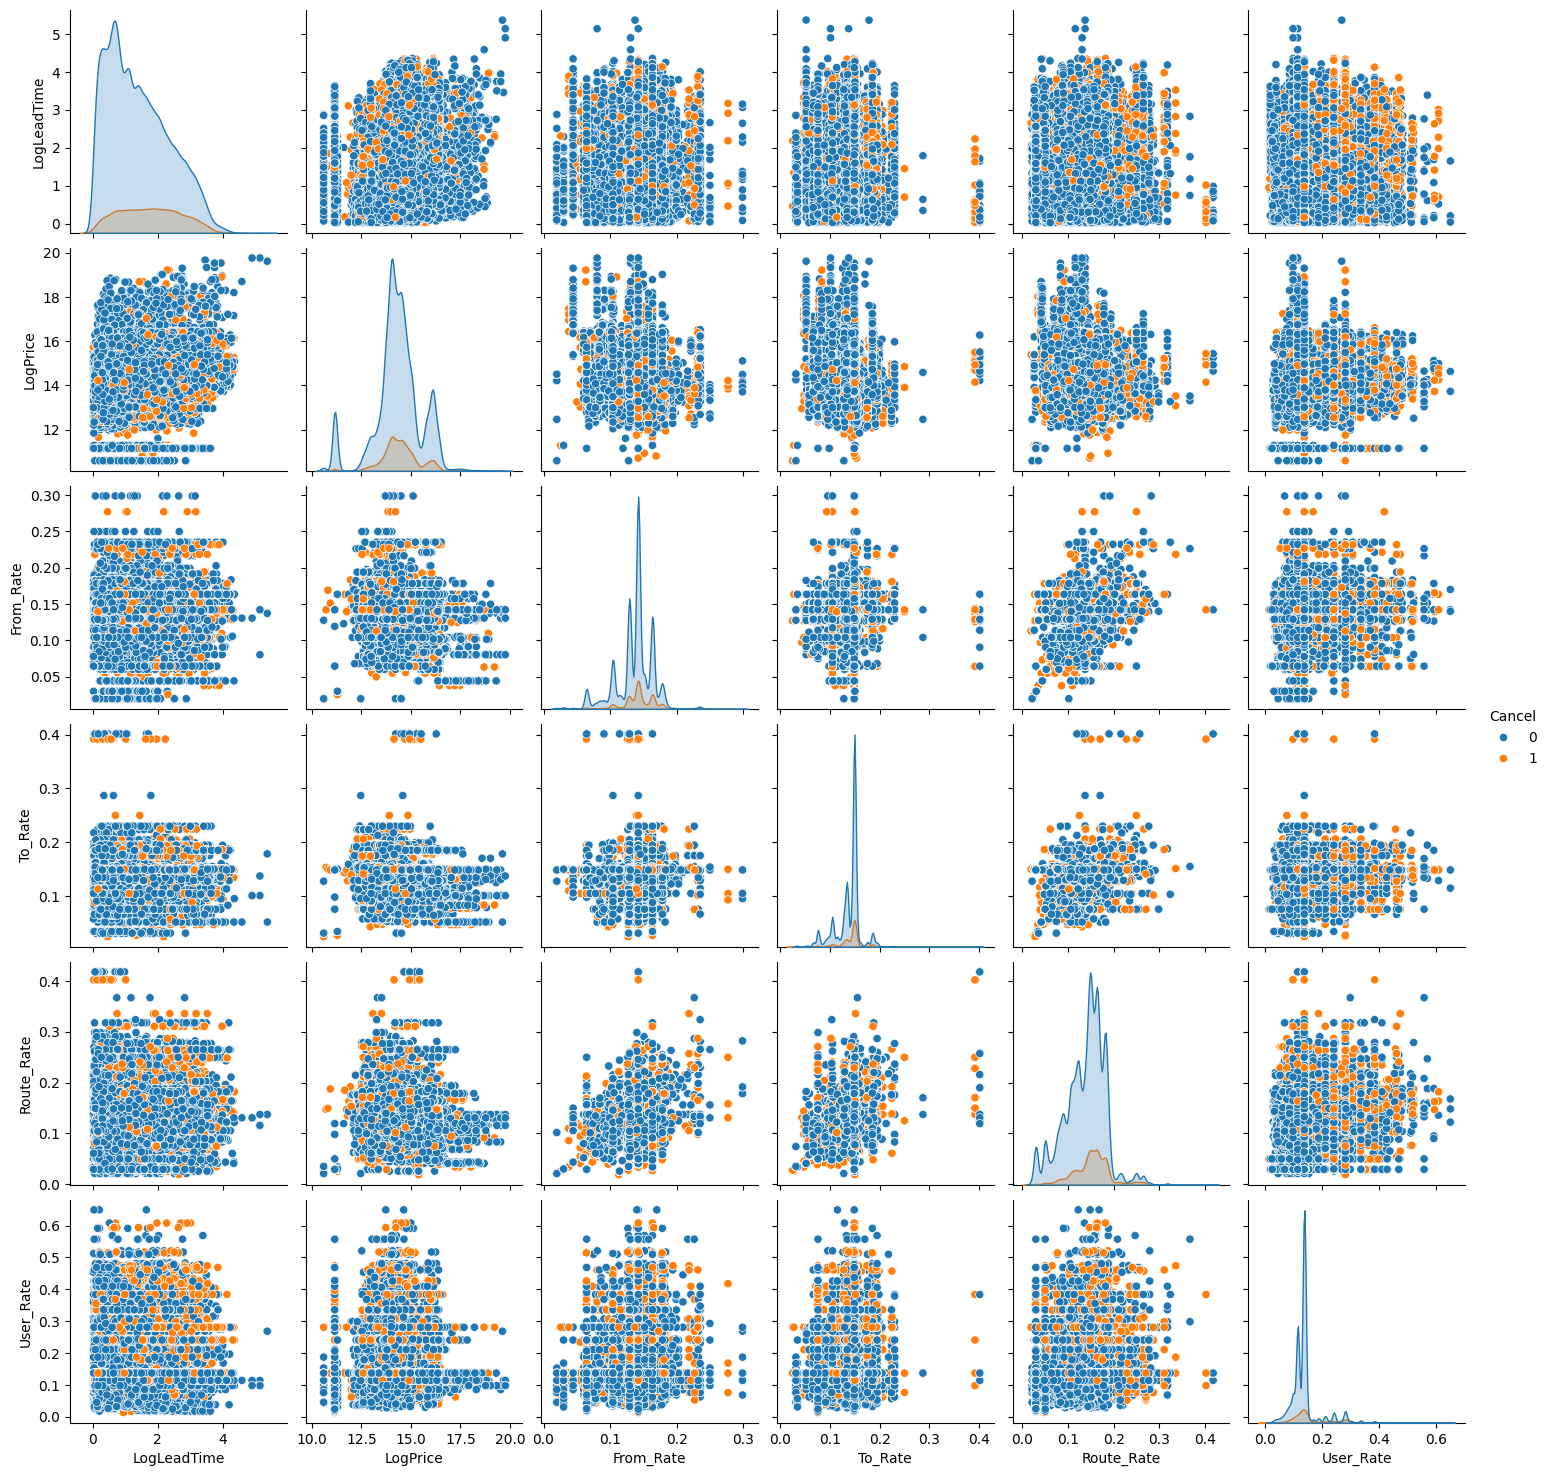

In [38]:
# Plotting pairwise relationships for continuous variables, colored by Cancel
plot_vars = cont_vars + [target_var]
sns.pairplot(data[plot_vars], hue=target_var, diag_kind='kde')
plt.show()

## Results

1. **High Predictive Power**

- User_Rate (Strongest Predictor)

Correlation: Even after correction, it holds a solid 0.20 correlation with Cancel, making it the single most predictive numerical feature.

Boxplot: The distribution for cancellations (orange box) is visibly shifted higher than for non-cancellations. The median user risk for those who actually cancel is distinct.

- Domestic

Barplot: The difference is stark. Domestic trips have a cancellation rate of ~15.2%, while international (non-domestic) trips are nearly half that at ~8.2%.

- Vehicle_Train

Barplot: Train trips show the highest cancellation probability (~18.5%) compared to the average. The error bars do not overlap with other vehicle types.

Correlation: Strong negative correlation with Vehicle_Bus (-0.76), meaning it effectively segments the transport mode risk.

- Route_Rate

Correlation: It has a correlation of 0.14 with Cancel, which is significantly stronger than From_Rate (0.08) or To_Rate (0.083).

VIF: VIF is 2.42 (Safe < 5).

- LeadTime_Days

Boxplot: The "cancellation" box (orange) has a much longer upper whisker and many more outliers. People who book very far in advance face higher uncertainty.

Correlation: Decent positive correlation of 0.11.



2. **Weak or Redundant**

- Male

Barplot: Identical heights (15.2% vs 14.9%). Error bars overlap completely.

Correlation: 0.0043 (virtually zero).

Action: Drop. It adds complexity with no predictive gain.

- TripReason

Barplot: Very slight difference, and error bars are close to overlapping. Effect size is small compared to Domestic.

Correlation: -0.016 (very weak).

Action: We still keep this variable and wait to check the statistics of the models.

- LogPrice

Correlation: Only 0.043 with Cancel, but fairly high (0.62) with Vehicle_Plane.

Redundancy: Planes are expensive; trains are cheap. Vehicle_Plane likely captures the "High Price" signal better than price itself.

Action: Drop. It is redundant with the vehicle type.

- From_Rate & To_Rate

Redundancy: Moderately correlated with Route_Rate (~0.53). Since Route_Rate has a higher correlation with the target (0.14 vs 0.08), it is the superior variable.

Action: we still keep these features, we want to feed either Route_Rate or From_Rate and To_Rate and see what works best.

In [39]:
data=data.drop(columns=['Male'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99330 entries, 0 to 99329
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Domestic             99330 non-null  int64  
 1   TripReason           99330 non-null  int64  
 2   Cancel               99330 non-null  int64  
 3   LogLeadTime          99330 non-null  float64
 4   LogPrice             99330 non-null  float64
 5   Vehicle_Bus          99330 non-null  int64  
 6   Vehicle_Plane        99330 non-null  int64  
 7   Vehicle_Train        99330 non-null  int64  
 8   TimeOfDay_Afternoon  99330 non-null  int64  
 9   TimeOfDay_Evening    99330 non-null  int64  
 10  TimeOfDay_Morning    99330 non-null  int64  
 11  TimeOfDay_Night      99330 non-null  int64  
 12  From_Rate            99330 non-null  float64
 13  To_Rate              99330 non-null  float64
 14  Route_Rate           99330 non-null  float64
 15  User_Rate            99330 non-null 

In [40]:
output_dir = "../data/"

os.makedirs(output_dir, exist_ok=True)

# Save the dataset
data.to_csv(os.path.join(output_dir, "updated_data.csv"), index=False)